In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [109]:
from envs.gridworld import GridworldEnv
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3, linewidth=80)

## ConRL Gridworld

In [8]:
env_shape = (8, 8)
env = gym.wrappers.TimeLimit(GridworldEnv(shape=env_shape))
num_episodes = 200
max_step = 1000
env._max_episode_steps = max_step
action_size = env.action_space.n
state_size = (env.observation_space.n, )

q_params = {
    "gamma": 0.5,
    "alpha": 1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.1,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}


q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 1, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 4, 
    "max_age": 10
}

In [34]:
stats_cr= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "mlgng_nodes":      [],
        "best_actions":     [],
}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
conrl.init_support(**q_params)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)

Episode 0/200, Reward -94.0, Total steps 94.0, Epsilon: 0.10, Alpha: 1.00, Time 0.028
	 MLGNG nodes per action layer: 0 0 0 0
Episode 100/200, Reward -12.0, Total steps 12.0, Epsilon: 0.10, Alpha: 1.00, Time 0.042
	 MLGNG nodes per action layer: 4 4 4 4


In [38]:
env_shape = (8, 8)
env = gym.wrappers.TimeLimit(GridworldEnv(shape=env_shape))
num_episodes = 200
max_step = 1000
env._max_episode_steps = max_step
action_size = env.action_space.n
state_size = (env.observation_space.n, )

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 1.0,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)




In [46]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 0/200, Reward -20.0, Total steps 20.0, Epsilon: 0.99, Alpha: 0.10, Time 0.004
Episode 100/200, Reward -4.0, Total steps 4.0, Epsilon: 0.10, Alpha: 0.10, Time 0.001


## Statistics

In [120]:
from src.plotting import *

act_symbol = {
    0:  "^",
    1: ">",
    2: "v",
    3: "<"
}

act_color = cm.Dark2(np.linspace(0, 1, 4))

act_dict = {
    0: "UP",
    1: "RIGHT",
    2: "DOWN",
    3: "LEFT"
}


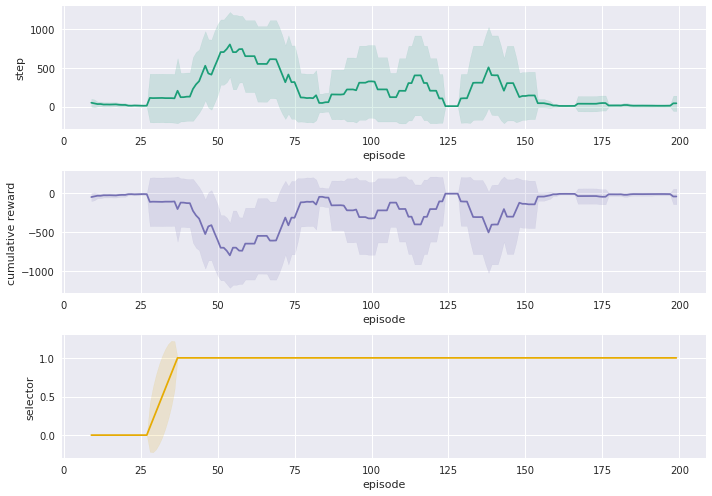

In [54]:
to_plot = ["step", "cumulative_reward", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
plot_stats(stats_to_plot, colors=act_color, figsize=(10, 7))

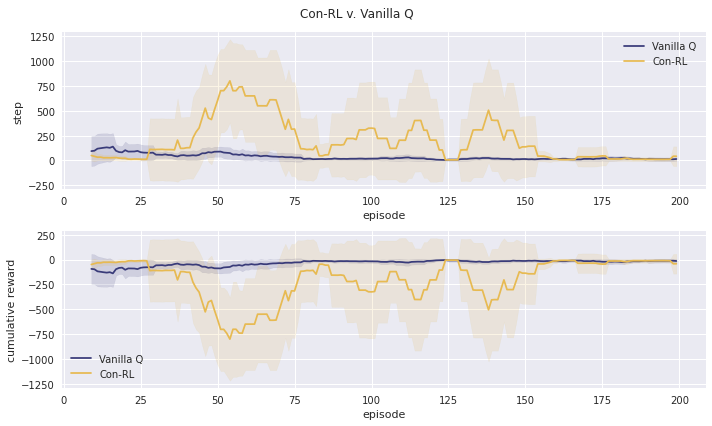

In [55]:
to_plot = ["step", "cumulative_reward"]
plot_stats_comparison({
    "Vanilla Q": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="Con-RL v. Vanilla Q")

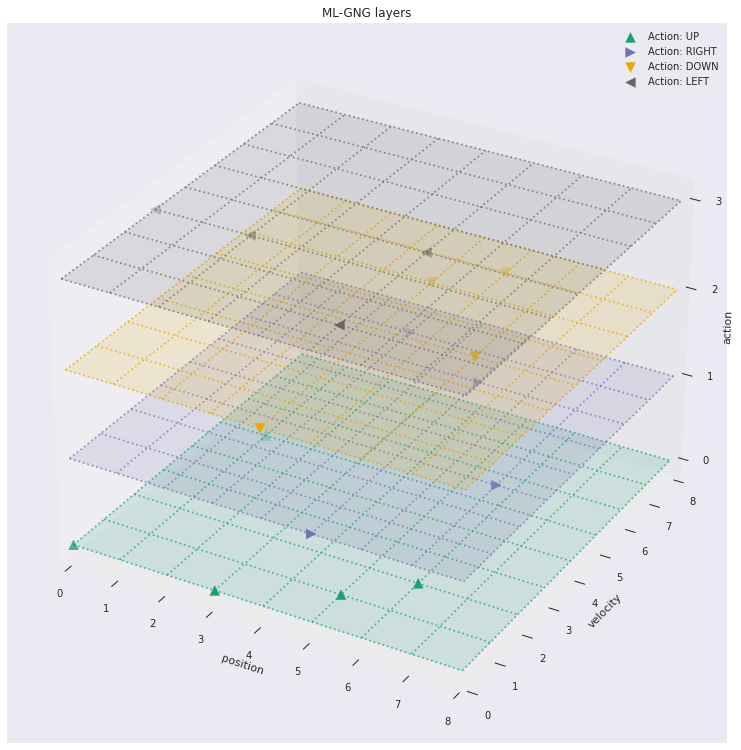

In [90]:
nodes = conrl.mlgng.get_nodes()

plot_nodes_3d(
            nodes=nodes, 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            unravel=True,
            axis_names=["position", "velocity", "action"])

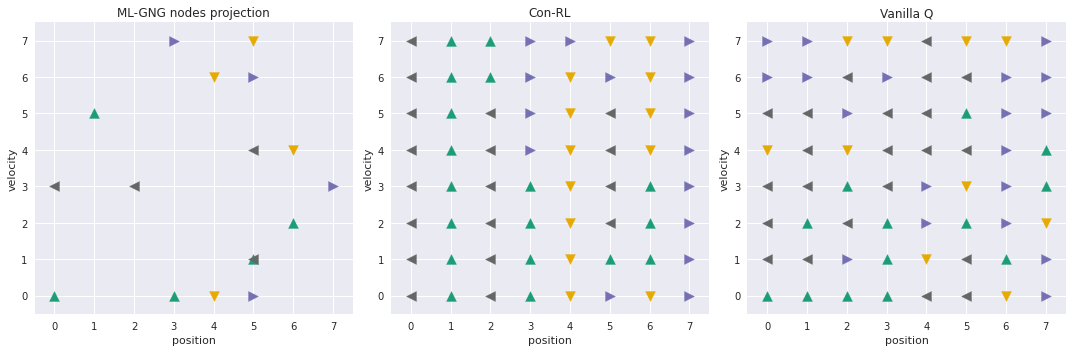

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            unravel=True,
            def_plot=(fig, ax[0]))

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            unravel=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            unravel=True,
            def_plot=(fig, ax[2]))

fig.tight_layout()

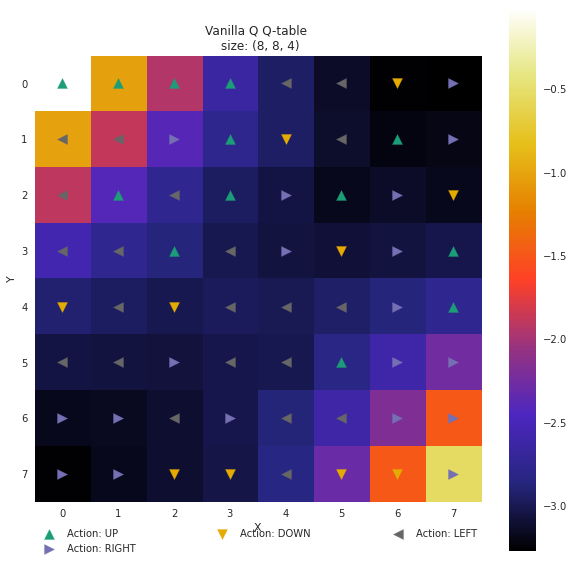

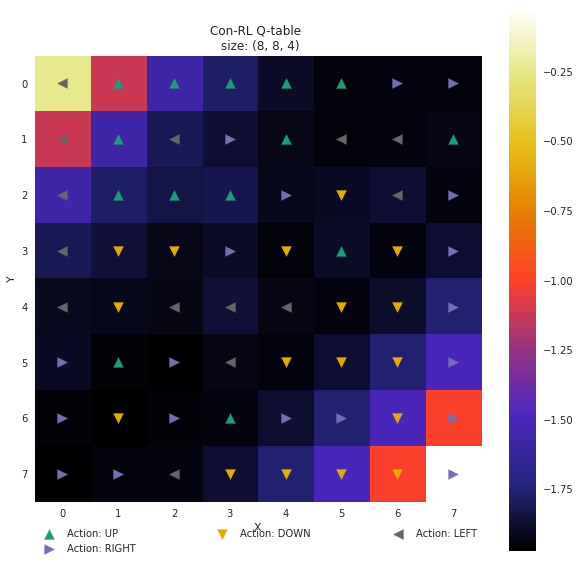

In [112]:
q = np.reshape(q_agent.Q, env_shape + (action_size, ))
q_cr = np.reshape(conrl.support.Q, env_shape + (action_size, ))

plot_q_table(q, 
            act_dict, 
            act_symbol, 
            act_color,
            title="Vanilla Q Q-table",
            axis_names=["X", "Y"],
            figsize=(10, 10))
plot_q_table(q_cr, 
            act_dict, 
            act_symbol, 
            act_color,
            title="Con-RL Q-table",
            axis_names=["X", "Y"],
            figsize=(10, 10))

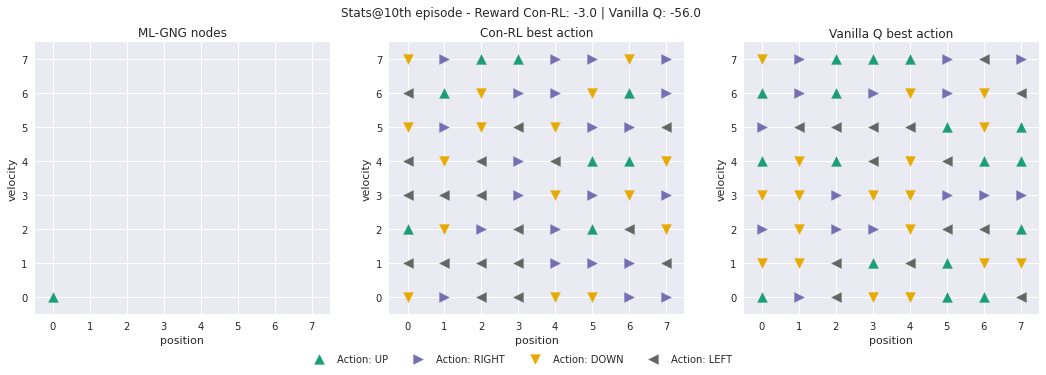

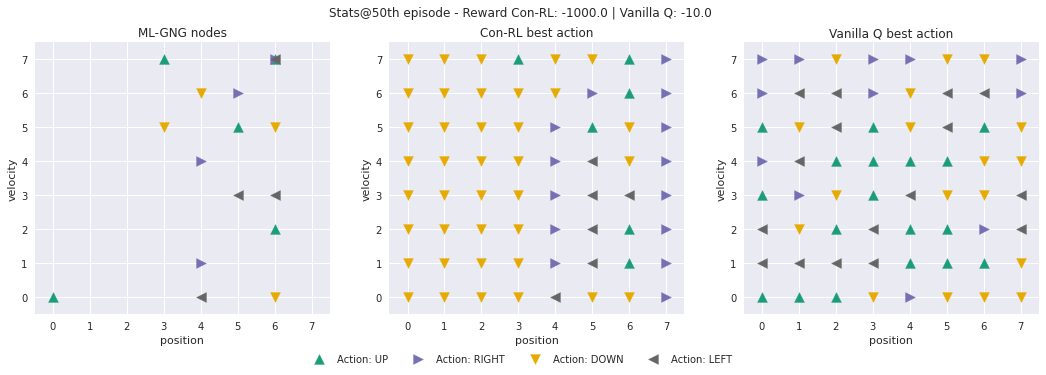

In [123]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 10
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            unravel=True,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            unravel=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            unravel=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=len(act_dict))


fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 50
fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            unravel=True,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL best action",
            round=True,
            unravel=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=env_shape, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q best action",
            round=True,
            labels=True,
            unravel=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=len(act_dict))